# Lung Illness Diagnosis with X-ray Images

This Jupyter notebook focuses on developing a deep learning model for diagnosing lung illnesses from X-ray images, including pneumonia, Covid-19, and normal scans. The goal is to assist medical professionals in interpreting X-ray scans effectively. The notebook uses the Keras module in TensorFlow and employs a multi-class classification approach.

# Dataset
The dataset used in this project is the "[Covid-19 Image Dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset)" which has been sourced from Kaggle. The dataset contains grayscale X-ray images, already split into training and testing sets. It is a multi-class classification problem, as it involves three different classes: Covid, Normal, and Pneumonia.

# Requirements
To run this project, you'll need the following libraries and tools:

* Python (3.6+)
* Jupyter Notebook
* TensorFlow
* Keras
* scikit-learn
* Matplotlib
* NumPy
* os module
* random module

# Project Structure
The project is organized into various sections within the Jupyter notebook:

* Importing Libraries

* Constructing ImageDataGenerator
  * Preparation of the data for model training.
  * Data augmentation techniques.

* Building the Convolutional Neural Network (CNN) Model
  * Compilation of the model with specified metrics and loss functions.

* Training the Model with Early Stopping
  * Implementation of early stopping to prevent overfitting.

* Model training with visualizations.
  * Visualizing training progress, including loss and accuracy curves.
  * Visualizing the confusion matrix.


In [25]:
# Importing Libraries 
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy
import seaborn as sns

In [2]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

validation_data_generator = ImageDataGenerator()

In [3]:
training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')

training_iterator.next()

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')

Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.


In [26]:
def display_sample_images(directory, class_labels, num_images=3):
    plt.figure(figsize=(12, 8))
    
    for i, class_label in enumerate(class_labels):
        class_dir = os.path.join(directory, class_label)
        image_files = os.listdir(class_dir)
        random_images = random.sample(image_files, num_images)
        
        for j, image_file in enumerate(random_images):
            image_path = os.path.join(class_dir, image_file)
            img = load_img(image_path, color_mode='grayscale', target_size=(256, 256))
            
            plt.subplot(len(class_labels), num_images, i * num_images + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Class: {class_label}')
            plt.axis('off')
    
    plt.show()


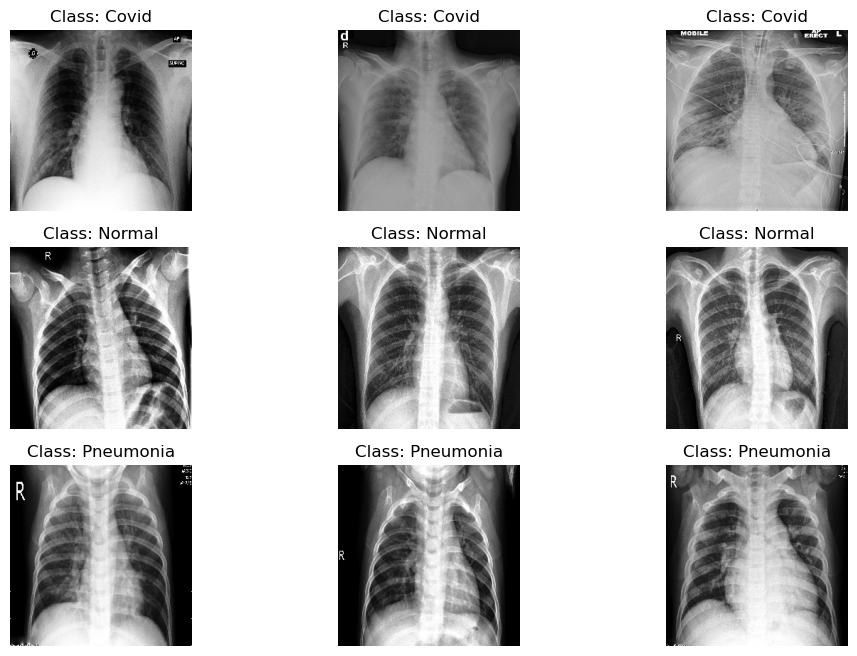

In [27]:
sample_directory = "Covid19-dataset/train"  # Change this to your dataset path
class_labels = ['Covid', 'Normal', 'Pneumonia']

display_sample_images(sample_directory, class_labels, num_images=3)

# Components of a Convolutional Neural Network:

__Convolutional Layers:__ These layers perform convolution operations on the input data to detect features like edges, corners, textures, or more complex patterns. Convolutional filters slide over the input to learn these features.

__Activation Function:__ Typically, ReLU (Rectified Linear Unit) is used as the activation function in CNNs to introduce non-linearity.

__Pooling (Subsampling) Layers:__ Pooling layers reduce the spatial dimensions of the data while retaining important information. Common pooling methods are max-pooling and average-pooling.

__Fully Connected Layers:__ These layers connect all neurons from one layer to all neurons in the next layer, like a traditional neural network. They are typically used in the final layers of the network for classification tasks.

__Output Layer:__ The output layer provides the final predictions or classifications. The activation function used depends on the nature of the task (e.g., softmax for multiclass classification).

In [5]:
# Building the Convolutional Neural Network (CNN) Model
#Print its attributes:
# print(training_data_generator.__dict__)


print("\nBuilding model...")

def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    # experimenting with extra layesr
    #model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Dropout(0.1))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model
    model.summary()
    return model


Building model...


__model = Sequential():__ This line creates a sequential model. A sequential model is a linear stack of layers, where you can add layers one by one. In this case, it's used to define the structure of the CNN.

__model.add(tf.keras.Input(shape=(256, 256, 1)):__ This line adds an input layer to the model. It specifies the shape of the input data, which is (256, 256, 1). It indicates that the model expects grayscale images with a size of 256x256 pixels

__model.add(layers.Conv2D(5, 5, strides=3, activation="relu")):__ This line adds a convolutional layer to the model. It applies 5 filters of size 5x5 to the input data. The strides=3 means that the filters move in steps of 3 pixels. The activation="relu" indicates that the rectified linear unit (ReLU) activation function is applied after the convolution.

__model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)):__ This line adds a max-pooling layer. Max-pooling reduces the spatial dimensions of the data by taking the maximum value within a 2x2 window and moving with a step of 2 pixels. It's used to downsample the feature maps.

__model.add(layers.Dropout(0.1)):__ This line adds a dropout layer. Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction (in this case, 10%) of input units to 0 during training.

__model.add(layers.Conv2D(3, 3, strides=1, activation="relu")):__ Similar to the first convolutional layer, this line adds another convolutional layer with 3 filters of size 3x3, a stride of 1, and ReLU activation.

__model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)):__ Another max-pooling layer is added to downsample the feature maps.

__model.add(layers.Dropout(0.2)):__ Another dropout layer with a 20% dropout rate is added.

__model.add(layers.Flatten()):__ This line adds a flatten layer, which is used to flatten the output from the previous layers into a one-dimensional vector. This is necessary before connecting to the fully connected layers.

__model.add(layers.Dense(3, activation="softmax"):__ The final output layer is added. It consists of 3 neurons, one for each class (Covid, Normal, Pneumonia). The softmax activation function is used to produce class probabilities.

__model.compile(...):__ This line compiles the model. It specifies the optimizer (Adam), loss function (categorical cross-entropy), and metrics (categorical accuracy and AUC) to be used for training and evaluation.

__model.summary():__ This line prints a summary of the model architecture, showing the layers and the number of parameters in each layer.

In [6]:
# use model function
model = design_model(training_iterator)


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 5)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 

In [7]:
# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

In [8]:
print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=5,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])


Training model...
Epoch 1/5
7/7 [==============================] - 10s 1s/step - loss: 1.0698 - categorical_accuracy: 0.4223 - auc: 0.6065 - val_loss: 33.6796 - val_categorical_accuracy: 0.4422 - val_auc: 0.5833
Epoch 2/5
7/7 [==============================] - 5s 704ms/step - loss: 1.0125 - categorical_accuracy: 0.4781 - auc: 0.6772 - val_loss: 21.4850 - val_categorical_accuracy: 0.5339 - val_auc: 0.6495
Epoch 3/5
7/7 [==============================] - 5s 674ms/step - loss: 0.9482 - categorical_accuracy: 0.5578 - auc: 0.7492 - val_loss: 11.2812 - val_categorical_accuracy: 0.7291 - val_auc: 0.8015
Epoch 4/5
7/7 [==============================] - 5s 672ms/step - loss: 0.8381 - categorical_accuracy: 0.7012 - auc: 0.8463 - val_loss: 8.4587 - val_categorical_accuracy: 0.8287 - val_auc: 0.8789
Epoch 5/5
7/7 [==============================] - 6s 730ms/step - loss: 0.7133 - categorical_accuracy: 0.7092 - auc: 0.8843 - val_loss: 11.6490 - val_categorical_accuracy: 0.8805 - val_auc: 0.9152


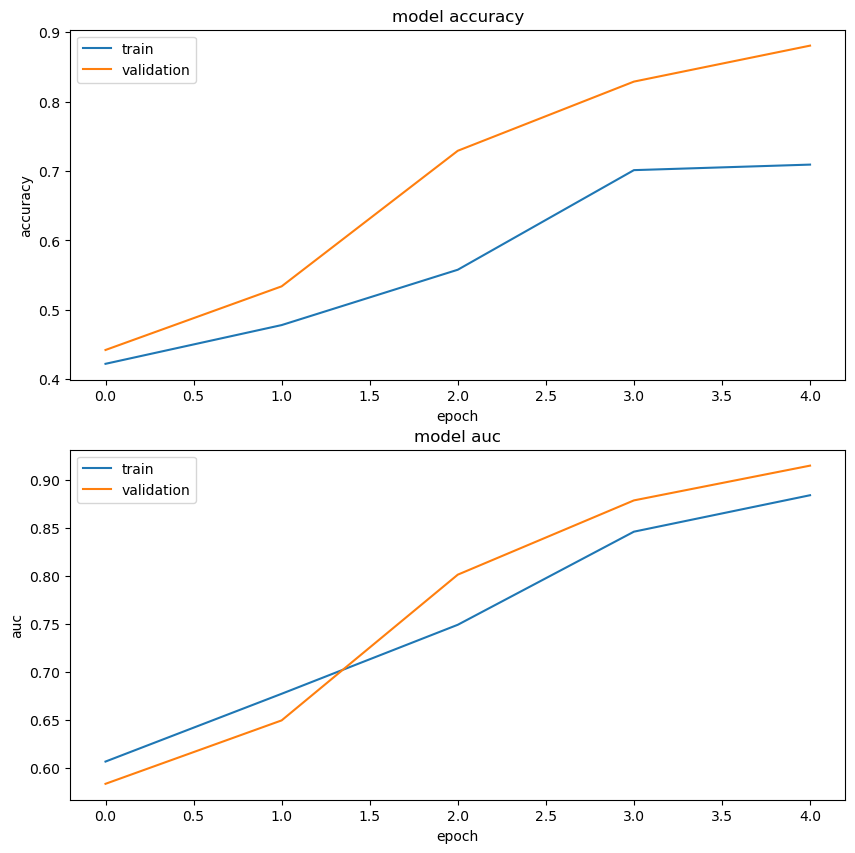

In [11]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

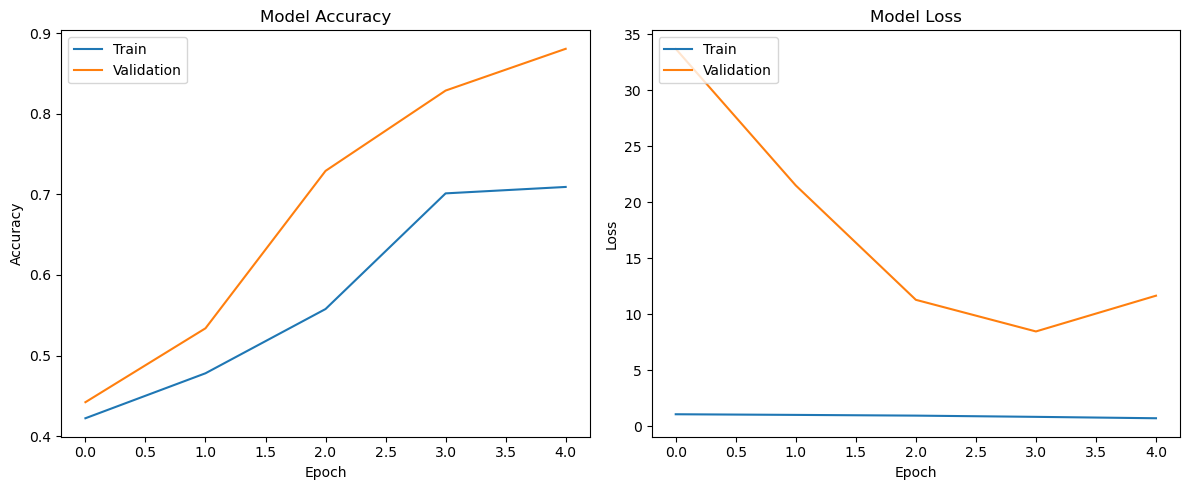

In [16]:
# Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

8/8 [==============================] - 1s 157ms/step
              precision    recall  f1-score   support

       Covid       0.47      0.45      0.46       111
      Normal       0.29      0.31      0.30        70
   Pneumonia       0.31      0.30      0.31        70

    accuracy                           0.37       251
   macro avg       0.36      0.35      0.35       251
weighted avg       0.37      0.37      0.37       251



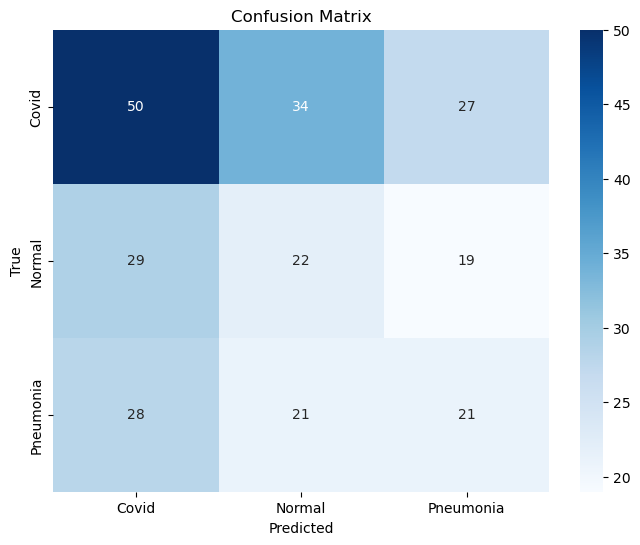

In [21]:
# Confusion Matrix Visualization
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[50 34 27]
 [29 22 19]
 [28 21 21]]
